In [1]:
import pickle
import numpy as np
from sklearn.preprocessing import RobustScaler,MinMaxScaler
X_ppg,X_qual,X_acc,y_rr, y_respiration,y_inspiration,y_expiration,groups,X_respiration,y_activity,y_label = pickle.load(open('../../affect-recognition/data/tabular_data_8.p','rb'))

In [ ]:
from scipy import signal
X_ppg = X_ppg.reshape(-1,512,1)
X_ppg = np.array([MinMaxScaler().fit_transform(signal.resample(a.reshape(-1),256).reshape(-1,1)) for a in X_ppg])
print(X_ppg.shape,X_acc.shape,y_label.shape)
X_acc = np.abs(X_acc + 2)

In [ ]:
# np.concatenate([X_ppg]*3,axis=2).shape
# X_acc = np.concatenate([X_ppg]*3,axis=2)
X_acc = X_ppg

In [ ]:
# example of training an conditional gan on the fashion mnist dataset
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input,GRU,Bidirectional
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D,Conv1D,MaxPool1D,BatchNormalization
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate

# define the standalone discriminator model
def define_discriminator(in_shape=(256,1), n_classes=9):
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 100)(in_label)
    # scale up to image dimensions with linear activation
    n_nodes = in_shape[0] * in_shape[1]
    li = Dense(n_nodes)(li)
    # reshape to additional channel
    li = Reshape((in_shape[0], in_shape[1]))(li)
    # image input
    in_image = Input(shape=in_shape)
    # concat label as a channel
    merge = Concatenate()([in_image, li])
    # downsample
    fe = Conv1D(100,4, padding='same',activation='tanh')(merge)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = MaxPool1D(2)(fe)
#     fe = BatchNormalization()(fe)
#     fe = Dropout(0.2)(fe)
    # downsample
    fe = Conv1D(200,8,padding='same',activation='tanh')(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = MaxPool1D(2)(fe)
    
    fe = Conv1D(100,8,padding='same',activation='tanh')(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = MaxPool1D(2)(fe)
    
#     fe = BatchNormalization()(fe)
#     fe = Dropout(0.4)(fe)
    # flatten feature maps
    fe = Flatten()(fe)
    # dropout
    fe = Dropout(0.4)(fe)
    # output
    fe  = Dense(10, activation='sigmoid')(fe)
    out_layer = Dense(1, activation='sigmoid')(fe)
    # define model
    model = Model([in_image, in_label], out_layer)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# define the standalone generator model
def define_generator(latent_dim, n_classes=9):
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # linear multiplication
    n_nodes = 1*1
    li = Dense(n_nodes)(li)
    # reshape to additional channel
    li = Reshape((1,1))(li)
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 7x7 image
    n_nodes = 1 * 1 
    gen = Dense(n_nodes)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((1, 1))(gen)
    # merge image gen and label input
    merge = Concatenate()([gen, li])
    # upsample to 14x14
    gen = Conv1D(8, 1, padding='same',activation='relu')(merge)
#     gen = LeakyReLU(alpha=0.2)(gen)
    gen = Conv1D(16, 1, padding='same',activation='relu')(gen)
#     gen = LeakyReLU(alpha=0.2)(gen)
    gen = Conv1D(32, 1, padding='same',activation='relu')(gen)
#     gen = LeakyReLU(alpha=0.2)(gen)
    gen = Conv1D(64, 1, padding='same',activation='relu')(gen)
#     gen = LeakyReLU(alpha=0.2)(gen)
    gen = Conv1D(128, 1, padding='same',activation='relu')(gen)
#     gen = LeakyReLU(alpha=0.2)(gen)
    gen = Conv1D(256, 1, padding='same',activation='sigmoid')(gen)
#     gen = LeakyReLU(alpha=0.2)(gen)
    out_layer = Reshape((256,1))(gen)
#     out_layer = Bidirectional(GRU(10,return_sequences=True,activation='sigmoid'))(out_layer)
#     out_layer = Dense(100,activation='linear')(out_layer)
#     out_layer = Dense(1,activation='linear')(out_layer)
#     # upsample to 28x28
#     gen = Conv2DTranspose(256, (4,4), strides=(2,2), padding='same')(gen)
#     gen = LeakyReLU(alpha=0.2)(gen)
#     # output
#     out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
    # define model
    model = Model([in_lat, in_label], out_layer)
    model.compile(loss='mse', optimizer='adam')
#     model = Model([in_label,in_lat],out_layer)
    return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    
    # get noise and label inputs from generator model
    gen_noise, gen_label = g_model.input
    # get image output from the generator model
    gen_output = g_model(g_model.input)
    # connect image output and label input from generator as inputs to discriminator
    gan_output = d_model([gen_output, gen_label])
    d_model.trainable = False
    # define gan model as taking noise and label and outputting a classification
    model = Model([gen_noise, gen_label], gan_output)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model
%matplotlib inline
# load fashion mnist images
def load_real_samples():
    # load dataset
#     (trainX, trainy), (_, _) = load_data()
    
    # expand to 3d, e.g. add channels
#     X = expand_dims(trainX, axis=-1)
#     # convert from ints to floats
#     X = X.astype('float32')
#     # scale from [0,255] to [-1,1]
#     X = (X - 127.5) / 127.5
    return [X_acc, y_activity]

# # select real samples
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    # choose random instances
    ix = randint(0, images.shape[0], n_samples)
    # select images and labels
    X, labels = images[ix], labels[ix]
    plt.figure()
    plt.plot(X[0])
    plt.title(labels[0])
    plt.ylabel('real')
    plt.show()
    # generate class labels
    y = ones((n_samples, 1))
    return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=9):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    plt.figure()
    plt.plot(images[0])
    plt.title(labels_input[0])
    plt.ylabel('fake')
    plt.show()
    # create class labels
    y = zeros((n_samples, 1))
    return [images, labels_input], y

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            # generate 'fake' examples
            [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_model.trainable = True
            d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
            # prepare points in latent space as input for the generator
            [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            d_model.trainable = False
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
            
            # summarize loss on this batch
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
    # save the generator model
    g_model.save('cgan_generator.h5')

# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()

d_model.summary()
# create the generator
g_model = define_generator(latent_dim)

g_model.summary()
# # create the gan
gan_model = define_gan(g_model, d_model)

gan_model.summary()
# # load image data
dataset = load_real_samples()
# # train model
train(g_model, d_model, gan_model, dataset, latent_dim)

In [ ]:
np.unique(np.round(y_activity))

In [86]:
import matplotlib.pyplot as plt

# plt.plot()
ppg1 = X_acc[10]
ppg1.shape

(256, 3)

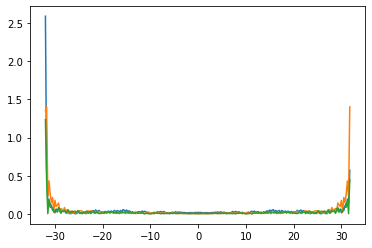

/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


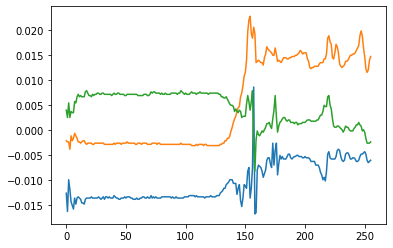

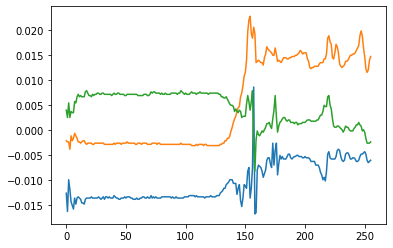

In [106]:
plt.plot(np.fft.fftshift(np.fft.fftfreq(256, 1/64)),np.abs(np.fft.fft(ppg1-np.mean(ppg1),axis=0)))
plt.show()
plt.plot(np.fft.ifft(np.fft.fft(ppg1,axis=1),axis=1))
plt.show()
plt.plot(ppg1)
# np.abs(np.fft.fftshift(np.fft.fft(ppg1-np.mean(ppg1),axis=1))).shape

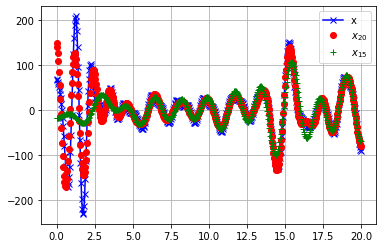

In [65]:
from scipy.fft import dct, idct
import matplotlib.pyplot as plt
N = ppg1.shape[0]
t = np.linspace(0,20,N)
x = ppg1.reshape(-1)
y = dct(x, norm='ortho')
window = np.zeros(N)
window[:40] = 1
yr = idct(y*window, norm='ortho')
sum(abs(x-yr)**2) / sum(abs(x)**2)

plt.plot(t, x, '-bx')
plt.plot(t, yr, 'ro')
window = np.zeros(N)
window[:25] = 1
yr = idct(y*window, norm='ortho')
sum(abs(x-yr)**2) / sum(abs(x)**2)

plt.plot(t, yr, 'g+')
plt.legend(['x', '$x_{20}$', '$x_{15}$'])
plt.grid()
plt.show()

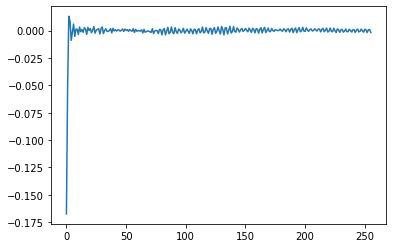

In [20]:
plt.plot(y)

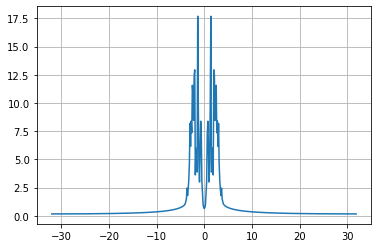

In [46]:
from scipy.fft import fft, fftfreq, fftshift
# number of signal points
N = ppg1.shape[0]
# sample spacing
T = 1.0 / 64
x = np.linspace(0.0, N*T, N)
y = ppg1.reshape(-1)
yf = fft(y)
xf = fftfreq(N, T)
xf = fftshift(xf)
yplot = fftshift(yf)
import matplotlib.pyplot as plt
plt.plot(xf, (1.0/N) * np.abs(yplot))
plt.grid()
plt.show()

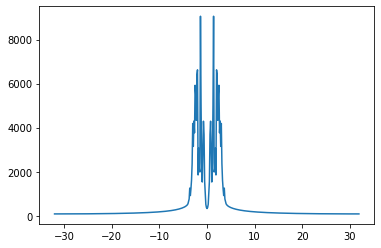

In [37]:
plt.plot(xf,np.abs(yplot))

In [47]:
# list(zip(xf,(1/N)*np.abs(yplot)))
 from scipy.stats import norm

(array([ 1.,  6., 13., 16., 23., 20., 13.,  5.,  0.,  3.]),
 array([-2.29121899, -1.79039558, -1.28957217, -0.78874876, -0.28792535,
         0.21289806,  0.71372146,  1.21454487,  1.71536828,  2.21619169,
         2.7170151 ]),
 <a list of 10 Patch objects>)

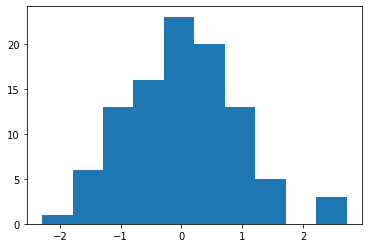

In [51]:
plt.hist(norm.rvs(size=100))

In [59]:
np.random.normal(1,.1,50)

array([1.07813337, 1.04270058, 1.03755219, 1.17113067, 1.03430533,
       1.10269835, 0.96490639, 1.03084692, 0.9771477 , 1.04370648,
       1.02788425, 1.01053223, 1.00707412, 1.08146052, 0.9538158 ,
       0.9845604 , 0.99654063, 1.03997785, 1.06216416, 1.17861307,
       0.88892666, 1.10757013, 1.13101048, 1.11192729, 1.01747703,
       1.01980968, 0.98576588, 1.15959658, 0.95074613, 0.96131681,
       0.9003751 , 1.07092527, 0.87541434, 1.15415533, 1.01485941,
       0.94755112, 0.7521395 , 1.03457056, 0.90239584, 0.99625771,
       0.9036022 , 1.18637476, 0.95921381, 0.98534438, 0.95093823,
       1.03284023, 1.05750914, 0.89643076, 1.00308674, 0.90444692])

In [110]:
np.fft.fft(ppg1,axis=1).real

array([[-0.01098633, -0.0135498 , -0.0135498 ],
       [-0.01635742, -0.01635742, -0.01635742],
       [-0.00708008, -0.01147461, -0.01147461],
       [-0.01342773, -0.01123047, -0.01123047],
       [-0.01196289, -0.015625  , -0.015625  ],
       [-0.01391602, -0.01574707, -0.01574707],
       [-0.01416016, -0.01672363, -0.01672363],
       [-0.00878906, -0.01611328, -0.01611328],
       [-0.01074219, -0.01696777, -0.01696777],
       [-0.00878906, -0.01611328, -0.01611328],
       [-0.00878906, -0.01574707, -0.01574707],
       [-0.00952148, -0.01574707, -0.01574707],
       [-0.00976562, -0.01599121, -0.01599121],
       [-0.01049805, -0.01672363, -0.01672363],
       [-0.01025391, -0.0168457 , -0.0168457 ],
       [-0.01049805, -0.01708984, -0.01708984],
       [-0.0090332 , -0.01635742, -0.01635742],
       [-0.00878906, -0.01611328, -0.01611328],
       [-0.0090332 , -0.01599121, -0.01599121],
       [-0.00952148, -0.01574707, -0.01574707],
       [-0.00952148, -0.01574707, -0.015

In [115]:
import tensorflow as tf
import keras.backend as K

In [145]:
y = X_ppg[30]
yf = tf.signal.fft(tf.complex(y,np.zeros((len(y)))))
yr = tf.signal.ifft(yf/(10498*2))

/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


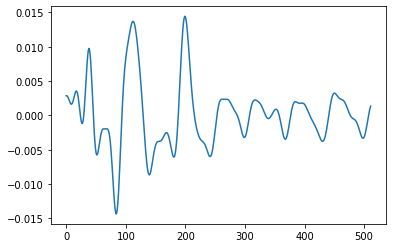

In [146]:
# plt.plot(y)
plt.plot(yr)

In [141]:
tf.math.real(yf).numpy().max(),tf.math.real(yf).numpy().min()

(10498.402490413446, -14543.616617890677)

(array([   53808.,   261394.,  5331831.,  8596542., 12269133.,  9741351.,
         7398320.,  5150100.,   753009.,   112608.]),
 array([-0.03125   , -0.02502441, -0.01879883, -0.01257324, -0.00634766,
        -0.00012207,  0.00610352,  0.0123291 ,  0.01855469,  0.02478027,
         0.03100586]),
 <a list of 10 Patch objects>)

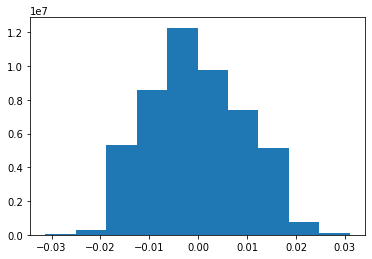

In [148]:
plt.hist(X_acc.reshape(-1))

In [150]:
X_acc.reshape(-1).min()

-0.03125